実験データを読み込みます...
データの読み込みに成功しました。読み込み件数: 174件
   Frequency (THz)  Transmittance (7.7T)
0         0.151441              0.035827
1         0.156326              0.036052
2         0.161212              0.034048
3         0.166097              0.030120
4         0.170982              0.024924
5         0.175867              0.019221
6         0.180752              0.013692
7         0.185638              0.008859
8         0.190523              0.005048
9         0.195408              0.002398
------------------------------

--- 検出されたピーク ---
     Frequency (THz)  Transmittance (7.7T)
1           0.156326              0.036052
29          0.293112              0.056956
77          0.527601              0.078814
129         0.781632              0.095241
------------------------------

--- 検出されたバレー（谷）---
     Frequency (THz)  Transmittance (7.7T)
11          0.205178              0.000304
46          0.376160              0.017721
102         0.649731              0.027799
155         0.908

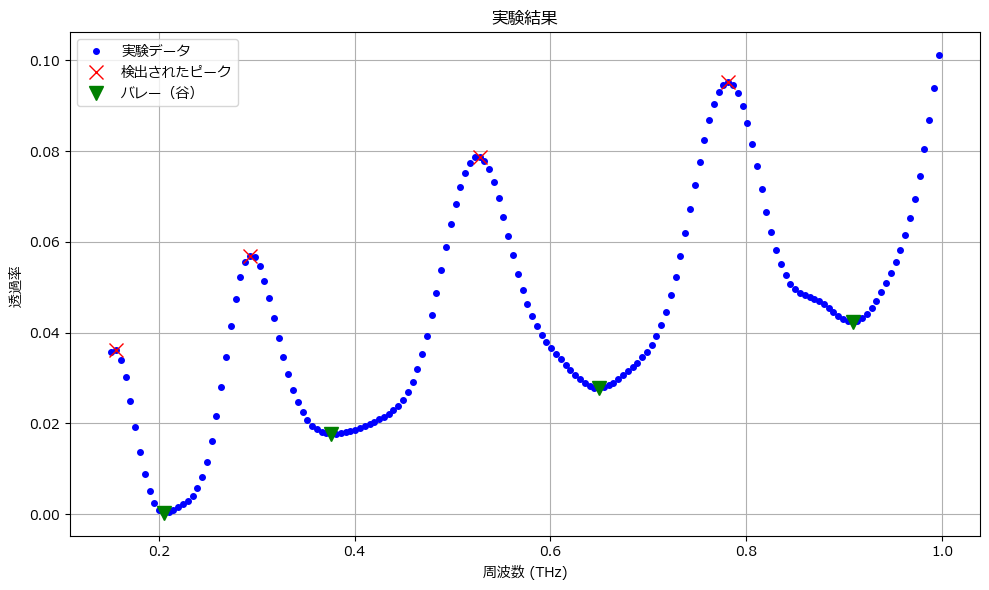

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0. プロット設定 ---
plt.rcParams['font.family'] = "Meiryo"
plt.rcParams['figure.dpi'] = 100


# --- 2. データの読み込みと準備 ---
print("実験データを読み込みます...")
file_path = "Circular_Polarization_B_Field.xlsx"
sheet_name = "Sheet2"
# pandasを使ってExcelファイルからデータを読み込む
# ファイル名を適宜確認・変更してください
try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    exp_freq_thz = df['Frequency (THz)'].to_numpy(dtype=float)
    exp_transmittance = df['Transmittance (7.7T)'].to_numpy(dtype=float)
    print(f"データの読み込みに成功しました。読み込み件数: {len(df)}件")
except FileNotFoundError:
    print(f"エラー: ファイルが見つかりません。パスを確認してください。\nパス: {file_path}")
    exit()
except Exception as e:
    # その他のエラー（例：シート名が違うなど）もキャッチ
    print(f"データの読み込み中にエラーが発生しました: {e}")
    exit()

print(df[['Frequency (THz)', 'Transmittance (7.7T)']].head(10))
print('-' * 30)

# a) ピーク（極大値）の検出
peak_indicates_all, _ = find_peaks(exp_transmittance, prominence=1e-4)

peak_data_all = df.iloc[peak_indicates_all]

print("\n--- 検出されたピーク ---")
print(peak_data_all[['Frequency (THz)', 'Transmittance (7.7T)']])
print("-" * 30) 

# b) バレー（極小値）の検出
# ★★★ データを反転させて、そのピークを探す ★★★
y_inverted_all = -exp_transmittance
valley_indices_all, _ = find_peaks(y_inverted_all, prominence=1e-4)
valley_data_all = df.iloc[valley_indices_all]
print("\n--- 検出されたバレー（谷）---")
print(valley_data_all[['Frequency (THz)', 'Transmittance (7.7T)']])

# --- 3. 結果の可視化 ---
fig, ax = plt.subplots(figsize=(10, 6))

# 元のデータをプロット
ax.plot(exp_freq_thz, exp_transmittance, 'o', color='blue', markersize=4, label='実験データ')


# 検出されたピークをプロット
ax.plot(peak_data_all['Frequency (THz)'], peak_data_all['Transmittance (7.7T)'], 
        'x', color='red', markersize=10, label='検出されたピーク')

# 検出されたバレーをプロット
ax.plot(valley_data_all['Frequency (THz)'], valley_data_all['Transmittance (7.7T)'], 
        'v', color='green', markersize=10, label='バレー（谷）', zorder=2)


ax.set_xlabel('周波数 (THz)')
ax.set_ylabel('透過率 ')
ax.set_title('実験結果')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
plt.close()

背景補正の計算が完了しました。


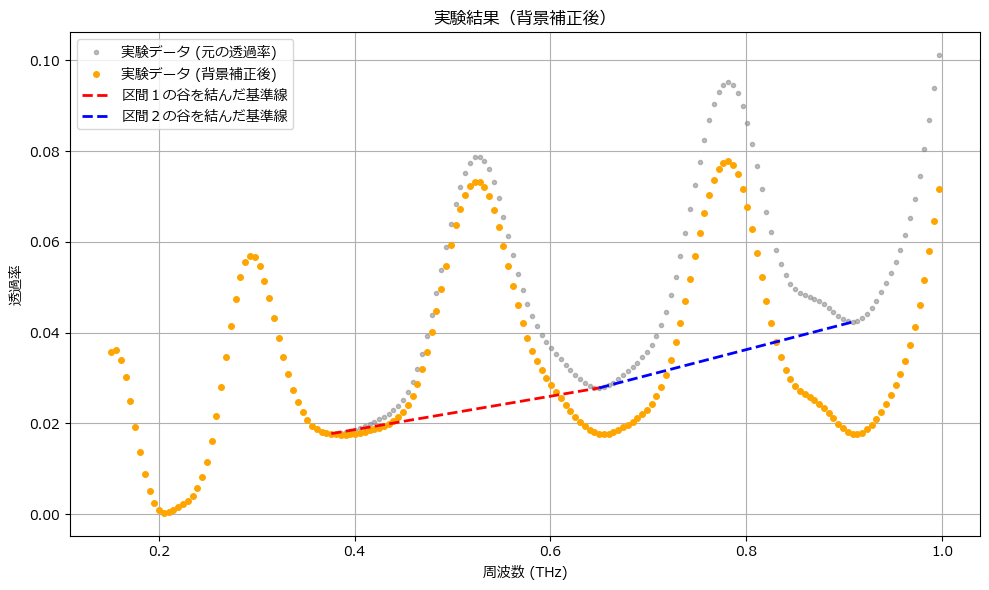

In [3]:
# --- 4. 背景透過率の補正 ---
# 以前のステップで計算済みの谷データを使用する
# valley_data_all のインデックス (行番号) を取得
valley_indices = valley_data_all.index

# 背景補正に使う谷のインデックスを動的に取得
try:
    # 2番目、3番目、4番目の谷を使用
    v_idx1, v_idx2, v_idx3 = valley_indices[1], valley_indices[2], valley_indices[3]
except IndexError:
    print("エラー: 背景補正に必要な数の谷が検出されていません。find_peaksのパラメータを調整してください。")
    exit()

# 谷の座標を動的に取得
x1, y1 = df.loc[v_idx1, 'Frequency (THz)'], df.loc[v_idx1, 'Transmittance (7.7T)']
x2, y2 = df.loc[v_idx2, 'Frequency (THz)'], df.loc[v_idx2, 'Transmittance (7.7T)']
x3, y3 = df.loc[v_idx3, 'Frequency (THz)'], df.loc[v_idx3, 'Transmittance (7.7T)']

# --- 背景の計算と減算（標準的なベースライン補正）---
# 補正用の配列を準備
exp_transmittance_corrected = df['Transmittance (7.7T)'].to_numpy(dtype=float).copy()

# ▼ 区間1（谷2 -> 谷3）の処理
slope1 = (y2 - y1) / (x2 - x1)
intercept1 = y1 - slope1 * x1  # 直線の切片を計算
# 対象区間のインデックスと周波数データを取得
idx_range1 = df.loc[v_idx1:v_idx2].index
freq_range1 = df.loc[idx_range1, 'Frequency (THz)'].to_numpy()
# y = mx + c で背景の直線そのものの値を計算
background1 = slope1 * freq_range1 + intercept1
# 元の透過率から背景の直線を差し引く
exp_transmittance_corrected[idx_range1] = df.loc[idx_range1, 'Transmittance (7.7T)'].to_numpy() - background1

# ▼ 区間2（谷3 -> 谷4）の処理
slope2 = (y3 - y2) / (x3 - x2)
intercept2 = y2 - slope2 * x2  # 直線の切片を計算
# 対象区間のインデックスと周波数データを取得
idx_range2 = df.loc[v_idx2:].index
freq_range2 = df.loc[idx_range2, 'Frequency (THz)'].to_numpy()
# y = mx + c で背景の直線そのものの値を計算
background2 = slope2 * freq_range2 + intercept2
# 元の透過率から背景の直線を差し引く
exp_transmittance_corrected[idx_range2] = df.loc[idx_range2, 'Transmittance (7.7T)'].to_numpy() - background2
# 区間1以降（インデックス46以降）にy1を加える処理
exp_transmittance_corrected[v_idx1:] += y1
print("背景補正の計算が完了しました。")


# --- 5. 修正後の結果の可視化 ---
# （このセクションは変更不要です）
fig, ax = plt.subplots(figsize=(10, 6))

# 元のデータをプロット
ax.plot(df['Frequency (THz)'], df['Transmittance (7.7T)'], 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元の透過率)')
# 修正後のデータをプロット
ax.plot(df['Frequency (THz)'], exp_transmittance_corrected, 'o', color='orange', markersize=4, label='実験データ (背景補正後)')

# 補正の基準とした谷を結ぶ線を描画
ax.plot([x1, x2], [y1, y2], '--', color='red', lw=2, label='区間１の谷を結んだ基準線')
ax.plot([x2, x3], [y2, y3], '--', color='blue', lw=2, label='区間２の谷を結んだ基準線')


ax.set_xlabel('周波数 (THz)')
ax.set_ylabel('透過率')
ax.set_title('実験結果（背景補正後）')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


--- 補正後データのピーク再検出とFWHM計算 ---
ピーク (周波数: 0.1563 THz) の半値幅: 0.0027 THz
ピーク (周波数: 0.2931 THz) の半値幅: 0.0537 THz
ピーク (周波数: 0.5227 THz) の半値幅: 0.0831 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0816 THz

--- 半値幅の計算が完了しました。 ---
平均半値幅: 0.0728 THz
平均半値幅 (共振器): 0.0823 THz


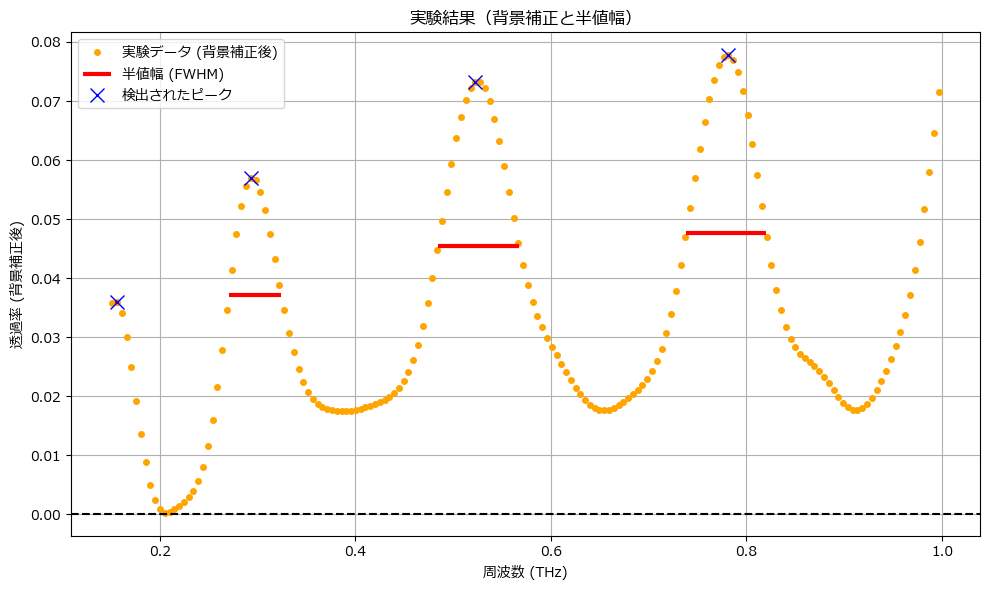

In [17]:
from scipy.signal import peak_widths # peak_widths関数をインポート

# --- 6. 補正後データのピーク再検出とFWHM計算 ---
print("\n--- 補正後データのピーク再検出とFWHM計算 ---")

# 背景補正後のクリーンなデータに対して、再度ピークを検出する
# height=0.001 は「ベースライン(y=0)から0.001以上突き出たものをピークとみなす」という設定
corrected_peak_indices, _ = find_peaks(exp_transmittance_corrected, height=0.001)

if len(corrected_peak_indices) == 0:
    print("エラー: 補正後のデータに顕著なピークが見つかりませんでした。heightの値を調整してください。")
else:
    # 新しく検出したピークに対して半値幅を計算する
    widths_info = peak_widths(exp_transmittance_corrected, corrected_peak_indices, rel_height=0.5)

    width_heights = widths_info[1]
    left_ips = widths_info[2]
    right_ips = widths_info[3]

    # 幅の左右の端点（インデックス単位）を、周波数（THz）に変換
    freq_axis = df['Frequency (THz)'].to_numpy()
    index_axis = np.arange(len(freq_axis))
    left_freqs = np.interp(left_ips, index_axis, freq_axis)
    right_freqs = np.interp(right_ips, index_axis, freq_axis)
    fwhm_in_thz = right_freqs - left_freqs

    # ピーク周波数を保存する
    corrected_peak_freqs = [] 

    # 結果を分かりやすく表示
    for i, peak_idx in enumerate(corrected_peak_indices):
        peak_freq = freq_axis[peak_idx]
        corrected_peak_freqs.append(peak_freq)
        print(f"ピーク (周波数: {peak_freq:.4f} THz) の半値幅: {fwhm_in_thz[i]:.4f} THz")
    print("\n--- 半値幅の計算が完了しました。 ---")
    gamma_average = np.mean(fwhm_in_thz[1:4])  # ピーク1~3の平均半値幅を計算
    gamma_average_cav = np.mean(fwhm_in_thz[2:4])  # 共振器モードの平均半値幅を計算
    print(f"平均半値幅: {gamma_average:.4f} THz")
    print(f"平均半値幅 (共振器): {gamma_average_cav:.4f} THz")
    # --- 7. 最終結果の可視化 ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['Frequency (THz)'], exp_transmittance_corrected, 'o', color='orange', markersize=4, label='実験データ (背景補正後)')
    # 新しく検出したピークの半値幅の線を描画
    ax.hlines(width_heights, left_freqs, right_freqs, color="red", lw=3, label="半値幅 (FWHM)")
    ax.plot(freq_axis[corrected_peak_indices], exp_transmittance_corrected[corrected_peak_indices],
            'x', color='blue', markersize=10, label='検出されたピーク')
    ax.set_xlabel('周波数 (THz)')
    ax.set_ylabel('透過率 (背景補正後)')
    ax.set_title('実験結果（背景補正と半値幅）')
    ax.legend()
    ax.grid(True)
    ax.axhline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

In [5]:
# 高次周波数(j次)に基づく膜厚の手計算
def calculate_thickness_from_peaks(j, peak_freqs):
    c = 299792458  # 光速 (m/s)
    n = 3.8 # 屈折率
    # ピーク周波数をTHzからHzに変換
    peak_freqs = peak_freqs * 1e12  # THz to Hz
    # ピーク周波数から膜厚を計算
    d_calculated = j * (c / (2 * n)) / peak_freqs
    d_calculated = d_calculated * 1e6  # m to μm 
    return d_calculated

In [ ]:
d_calculated = []
# ピーク周波数から膜厚を計算
for j in range(2, 4): 
	thickness = calculate_thickness_from_peaks(j, corrected_peak_freqs[j])  # j-2は0-indexedのため
	print(f"{j}次周波数: {corrected_peak_freqs[j]}")
	d_calculated.append(thickness)
	print(f"{j}次周波数に基づく膜厚の計算結果: {thickness:.3f}μm")

d_average = np.mean(d_calculated)
print(f"\n平均膜厚: {d_average:.3f}μm")

2次周波数: 0.522716170004885
2次周波数に基づく膜厚の計算結果: 150.928μm
3次周波数: 0.781631656082071
3次周波数に基づく膜厚の計算結果: 151.400μm

平均膜厚: 151.164μm
平均半値幅: 0.0728 THz
平均半値幅 (共振器): 0.0823 THz


In [7]:
eps_bg = 3.8**2
print(f"\n背景誘電率: {eps_bg}")


背景誘電率: 14.44
